## ANN for regression, example 1, house energy bill estimation

##### Version 2: using some common optimization approaches (inspecting variable importance, neural network normalization, regularization, ModelCheckpoint etc.)

#### Imports / modules

In [1]:
# pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

#### Loading the dataset

In [2]:
# load the csv-file to pandas DataFrame
df = pd.read_csv("Household energy bill data.csv")

In [3]:
# quickly check the first few rows of data
# to see what we have here
df.head()

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
0,3,3,742.57,1,1,1,9675.93,2,0,560.481447
1,1,5,952.99,0,1,0,35064.79,1,1,633.283679
2,3,1,761.44,1,1,1,22292.44,0,0,511.879157
3,0,5,861.32,1,1,0,12139.08,0,0,332.992035
4,1,8,731.61,0,1,0,17230.10,2,1,658.285625


#### X/y-split

In [4]:
# perform X/y -split
# if you  have more than one independent variable, list them all here
# leave out the target variable! (dependent variable)

# this is a nice and common trick => everything EXCEPT target variable => support variable
X = df.drop("amount_paid", axis=1)

# have only the target variable here (dependent variable)
y = df["amount_paid"]

### Inspect the variables: which ones are important, and are there any redundant ones we could remove

In [5]:
# the most basic tool of them all => correlations
correlations = df.corr(numeric_only=True)
correlations

# based on this: num_rooms, num_people, ave_monthly_income have very 
# small correlations towards the target variable (amount_paid)

# remember: correlations only measure linear connection, if the 
# relationship between variables is more complex, correlations often
# fail to recognize that

,num_rooms,num_people,housearea,is_ac,is_tv,is_flat,ave_monthly_income,num_children,is_urban,amount_paid
num_rooms,1.000000,-0.005765,-0.033561,0.018620,-0.016146,0.004133,-0.000345,-0.037474,-0.015705,-0.023933
num_people,-0.005765,1.000000,0.000072,0.033672,0.020101,0.012104,0.019152,-0.010656,-0.023863,0.053501
housearea,-0.033561,0.000072,1.000000,0.036039,0.088323,0.007986,-0.042645,0.038699,0.024902,0.096157
is_ac,0.018620,0.033672,0.036039,1.000000,-0.000247,0.002678,-0.014054,-0.027256,-0.053317,0.390003
is_tv,-0.016146,0.020101,0.088323,-0.000247,1.000000,-0.028155,0.013664,0.015353,0.034774,0.197613
is_flat,0.004133,0.012104,0.007986,0.002678,-0.028155,1.000000,-0.014879,-0.028315,-0.000066,0.147927
ave_monthly_income,-0.000345,0.019152,-0.042645,-0.014054,0.013664,-0.014879,1.000000,0.008329,-0.039424,0.025889
num_children,-0.037474,-0.010656,0.038699,-0.027256,0.015353,-0.028315,0.008329,1.000000,-0.007511,0.447512
is_urban,-0.015705,-0.023863,0.024902,-0.053317,0.034774,-0.000066,-0.039424,-0.007511,1.000000,0.649568
amount_paid,-0.023933,0.053501,0.096157,0.390003,0.197613,0.147927,0.025889,0.447512,0.649568,1.000000


#### Fisher's score (read comments below for details)

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\skfeature\function\similarity_based\fisher_score.py:59: RuntimeWarning: divide by zero encountered in divide
  score = 1.0 / lap_score - 1


<Axes: >

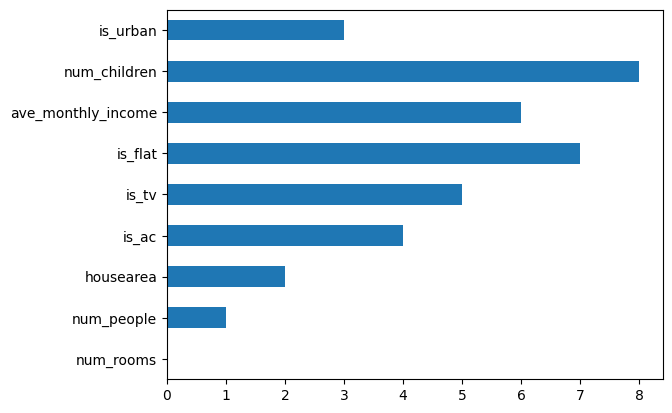

In [6]:
# pip install skfeature-chappers
from skfeature.function.similarity_based import fisher_score

# get the fisher's score rankings 
ranks = fisher_score.fisher_score(X.values, y.values)

# create a pandas DataFrame for easier interpretation
feat_importances = pd.Series(ranks, X.columns)
feat_importances.plot(kind='barh')

# how to interpret -> low score means the effect of this field is not large in the dataset
# => typically means other columns in the dataset have similar correlations, 
# therefore making this particular column not so useful since other columns 
# already fill this role for this correlation

# Fisher's score studies the variance of the data -> statistical significance'

# based on Fisher's score:
# num_rooms is not important at all, and num_people has minor importance in this data
# but ave_monthly_income is quite powerful based on Fisher's score

#### SelectKBest-score can also be used to decide important variables (and variables that are not that useful)

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on target variable
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:302: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  self.y_type_ = type_of_target(y, input_name="y")
c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\sklearn\preprocessing\_label.py:359: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_is_multilabel = type_of_target(y).startswith("multila

,Features,Score
6,ave_monthly_income,2006145.61
2,housearea,13910.07
7,num_children,502.97
1,num_people,403.81
3,is_ac,365.11
0,num_rooms,279.78
8,is_urban,277.52
5,is_flat,276.65
4,is_tv,106.27


#### Train/test/validation -split

In [8]:
# in Classic ML, we only had train/test -split
# in deep learning, we usually use validation-data also, for better
# optimization possibilities and better metrics

# unfortunately the scikit-learn's train_test_split doesn't support validation
# set split in itself.

# if you want to split the test set into two for a validation set too, try this trick:

# step 1, split the data into 70% (training data) and 30% (temporary data)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

# step 2, split the temporary data in HALF (0.5) => 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

#### Create a neural network structure

Here we apply many optimization methods => ModelCheckpoint, BatchNormalization, regularisation...

BatchNormalization is actually often REQUIRED for the neural network to work properly. In a nutshell: Normalization scales all values between a certain range, like between 0 and 1. This means, smallest value will be assigned to 0 and highest value to 1. Any other value than these will be a decimal in between (average value is often close to 0.5)

In [9]:
# create neural network

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# save the amount of support variables into a helper variable
# so we don't have to update the input_shape all the time
variable_amount = len(X.columns)

# create callbacks and place them into a parameter list
# NOTE! if you get PermissionError while training the model,
# just try training it again
mc = ModelCheckpoint('best_model_regression1_energybill.keras', monitor='val_loss', mode='min', save_best_only=True)

# if you use multiple callbacks (EarlyStoppin, ReduceLROnPlateau etc.)
# add them to this same list
callback_list = [mc]

# let's try some common optimization approaches

# neural networks often need at least a normalization layer
# so that it updates all weight values fairly 
# typically the original dataset has various scales of numbers
# which confuses neural network while it's training itself
# luckily we have the BatchNormalization -layer in keras!

# regularization is often beneficial in neural networks
# but it's usually better to apply this a bit later
# once you know approximately a working neural network structure for your data
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(variable_amount,)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dropout(0.1),
        layers.Dense(10, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(1)
    ]
)

# select the optimizer and loss function
# you can try rmsprop also as optimizer, or stochastic gradient descent
model.compile(optimizer='adam', loss='mse')

# common tips on how to change neural network structure if your metrics are not good:

# make wider (or narrower) layers (for example, 64 or 128 nodes)
# make a longer or shorter network (add or remove layers)
# use Dropout -layers (e.g. layers.Dropout(0.1))

# remember: there's no process or mathematical formula
# in order to figure out the optimal neural network structure
# it's mostly all about trial and error => EXPERIMENTATION!

# remember to have enough "decision-space" for your data!
# it's highly unlikely a dataset with 20 different variables is going
# to work well with only 8 nodes in each layer etc.

# print out the summary of your model
model.summary()

c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 9)              │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463 (1.81 KB)

 Trainable params: 445 (1.74 KB)

 Non-trainable params: 18 (72.00 B)

#### Train the neural network (notice how we connect the callbacks here, this enables ModelCheckpoint etc.)

In [10]:
# train/fit neural network with validation data
# see the instructions on the train/test -split above on how to split the data correctly
model.fit(x=X_train, y=y_train, epochs=1200, validation_data=(X_val, y_val), callbacks=callback_list)

Epoch 1/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 404012.0312 - val_loss: 372999.1875
Epoch 2/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 403475.5625 - val_loss: 372014.8750
Epoch 3/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 402851.7812 - val_loss: 370844.3750
Epoch 4/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 401940.1562 - val_loss: 369256.5938
Epoch 5/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 400325.1250 - val_loss: 366787.0938
Epoch 6/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 397633.1562 - val_loss: 362614.1562
Epoch 7/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 393051.0625 - val_loss: 355558.0000
Epoch 8/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 384867.8438 - val_loss: 344049.8125
Epoch 9/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 372031.7812 - val_loss: 326099.4375
Epoch 10/1200
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 350705.5312 - val_loss: 298971.3750
Epoch 11/1200
22/22 ━━━━━━━━━━━━━━━━━━

#### Performance and error metrics in order to see if the model trained and works well

<Axes: >

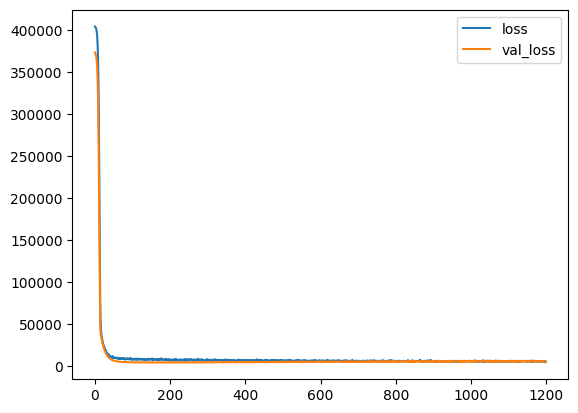

In [11]:
# let's use pandas for this (easy code)
# try to look if the model is actually training 
# => the error is going downwards
# if using validation data, you get two lines
# in this case, see if the lines follow a similar trend 
# (they don't always overlap with complex data, the trend is more important)
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Since we used ModelCheckpoint, we have to load the best model version again at this point

In [12]:
# replace the model from last epoch with best epoch from training history
from keras.models import load_model
model = load_model("best_model_regression1_energybill.keras")

In [13]:
# compare the final model loss/evaluation values
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
4100.01123046875

Train data evaluation:
3933.709716796875


In [14]:
# get test predictions
test_predictions = model.predict(X_test)

# reshape the data for easier comparison table
test_predictions = pd.Series(test_predictions.reshape(len(y_test),))
pred_df = pd.DataFrame(np.asarray(y_test), columns=['Test True Y'])
pred_df = pd.concat([pred_df, test_predictions], axis=1)
pred_df.columns = ['Test True Y', 'Model Predictions']

# print the comparison table - true values vs. model predicted values
# we can nicely see here how far off our model is in some cases
pred_df

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Test True Y,Model Predictions
0,650.92,531.25
1,371.24,384.52
2,823.76,841.01
3,282.07,372.95
4,393.30,361.62
...,...,...
145,879.02,752.54
146,567.59,615.66
147,556.37,617.15
148,616.09,675.23


<Axes: xlabel='Test True Y', ylabel='Model Predictions'>

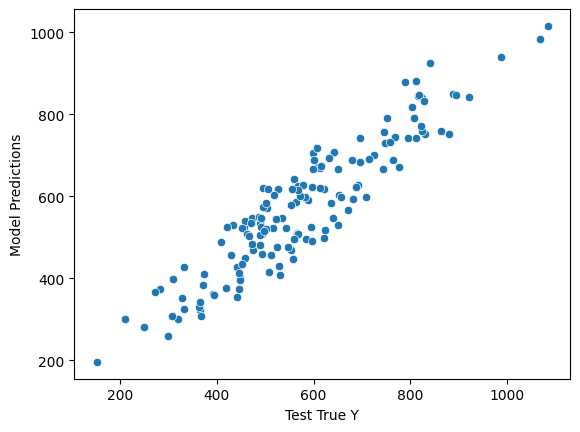

In [15]:
# these values follow a linear diagonal line = good predictions
# we basically compare the predicted values 
# to true test values and see the differences
sns.scatterplot(x='Test True Y', y='Model Predictions', data=pred_df)

# looks pretty decent!

#### The metrics are way better this time! (Compare to the original version from lecture 1)

In [16]:
# MAE - Mean average error
print("MAE")
print(round(metrics.mean_absolute_error(y_test, test_predictions), 2), "$")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(y_test, test_predictions), 2), "$^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(y_test, test_predictions)), 2), "$")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(y_test, test_predictions), 2))

# Explained Variance Score => 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
# high variance score = model is a good fit for the data 
# low variance score = model is not a good fit for the data
# the higher the score, the model is more able to explain the variation in the data
# if score is low, we might need more and better data
print("\nExplained variance score:")
print(round(metrics.explained_variance_score(y_test, test_predictions), 2))

MAE
54.88 $

MSE
4093.26 $^2

RMSE:
63.98 $

R-squared:
0.86

Explained variance score:
0.86


#### From 109 RMSE  to ~64, quite decent optimization, even though there is still room for improvement

C:\Users\tuomas.valtanen\AppData\Local\Temp\ipykernel_2440\3124900743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_test - test_predictions))


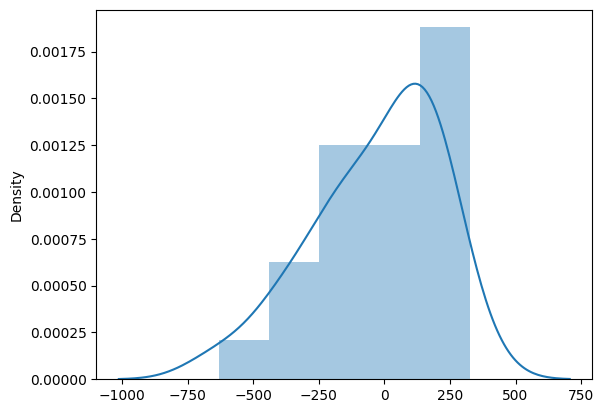

In [17]:
# if the prediction distribution are far from normal distribution
# then the model is not probably good enough
# distplot is deprecating in future pandas-version
# unfortunately, there's no exact alternative to do this plot at the moment
sns.distplot((y_test - test_predictions))
plt.show()
plt.close()

In [18]:
df.columns

Index(['num_rooms', 'num_people', 'housearea', 'is_ac', 'is_tv', 'is_flat',
       'ave_monthly_income', 'num_children', 'is_urban', 'amount_paid'],
      dtype='object')

#### Trying the model in practice with new imaginary house

In [19]:
# let's try with some new imaginary data
# this example uses the student performance index score dataset
# modify this as needed regarding your own dataset
tester_row = {
    'num_rooms': 7, 
    'num_people': 2, 
    'housearea': 350, 
    'is_ac': 0, 
    'is_tv': 0, 
    'is_flat': 0,
    'ave_monthly_income': 1500, 
    'num_children': 0, 
    'is_urban': 0
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])

In [20]:
# get the prediction from the model and print out the result
result = model.predict(tester_row)[0]

print()
print(f"Estimated energy bill for this house:")
print(f"$ {round(float(result[0]), 2)}")
print("----------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

Estimated energy bill for this house:
$ 227.8
----------------
